In [1]:
import pandas as pd
import psycopg2
from dotenv import load_dotenv
import os

# Load .env from current directory
load_dotenv('.env')

# Read env variables (use defaults or None if missing)
PG_USER = os.getenv('PG_USER')
PG_PASSWORD = os.getenv('PG_PASSWORD')
PG_HOST = os.getenv('PG_HOST', 'localhost')
PG_PORT = os.getenv('PG_PORT', '5432')
PG_DB = os.getenv('PG_DB')


try:
    # Connect to PostgreSQL
    conn = psycopg2.connect(
        dbname=PG_DB,
        user=PG_USER,
        password=PG_PASSWORD,
        host=PG_HOST,
        port=PG_PORT
    )

    # Example: load energy_consumption_hourly
    data = pd.read_sql('SELECT * FROM energy_consumption_hourly', conn)
    
    # Create a cursor to execute SQL
    cur = conn.cursor()
    
    # Run a simple query to test connection
    cur.execute("SELECT version();")
    version = cur.fetchone()
    print("Connection successful! PostgreSQL version:", version[0])
    
    # Close cursor and connection
    cur.close()
    conn.close()
    
except Exception as e:
    print("Connection failed:", e)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_21312\790026072.py:28: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql('SELECT * FROM energy_consumption_hourly', conn)


Connection successful! PostgreSQL version: PostgreSQL 16.10 (Debian 16.10-1.pgdg13+1) on x86_64-pc-linux-gnu, compiled by gcc (Debian 14.2.0-19) 14.2.0, 64-bit


In [5]:
data.head()

,time_ts,building,winter_flag,spring_flag,summer_flag,fall_flag,outdoor_temp_c,humidity_pct,cloud_cover_pct,solar_radiation_w_m2,...,day_of_week,month_num,day_of_year,is_weekend,is_holiday,is_peak_hour,lighting_kw,hvac_kw,special_equipment_kw,use_kw
0,2023-01-01 00:00:00,Hospital,1,0,0,0,-10.00,90.36,42.76,0.0,...,6,1,1,1,1,0,1.7337,2.9853,6.0873,10.8217
1,2023-01-01 01:00:00,Hospital,1,0,0,0,-10.00,90.90,50.11,0.0,...,6,1,1,1,1,0,1.6887,3.5390,6.3083,11.2541
2,2023-01-01 02:00:00,Hospital,1,0,0,0,-10.00,90.71,38.84,0.0,...,6,1,1,1,1,0,1.7212,3.6485,5.9951,11.4253
3,2023-01-01 03:00:00,Hospital,1,0,0,0,-9.81,90.44,34.33,0.0,...,6,1,1,1,1,0,1.6233,4.4524,6.0594,11.9859
4,2023-01-01 04:00:00,Hospital,1,0,0,0,-8.27,88.83,24.28,0.0,...,6,1,1,1,1,0,1.6414,4.9425,6.4094,12.8251


In [6]:
df = data.copy()
df['time_ts'] = pd.to_datetime(df['time_ts'])   # Convert to datetime to ensure proper handling

# Training model = GRU (Gated Recurrent Unit) :

### Correlarion analysis :

In [10]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import numpy as np

# Make a copy to avoid modifying original
df_copy = df.copy()

target = 'use_kw'

# Encode non-numeric columns (categorical features)
for col in df_copy.columns:
    if df_copy[col].dtype == 'object':
        df_copy[col] = LabelEncoder().fit_transform(df_copy[col].astype(str))

# Drop timestamp columns (not useful directly)
df_copy = df_copy.drop(columns=['time_ts'], errors='ignore')

# Separate features and target
X = df_copy.drop(columns=[target])
y = df_copy[target]

# Compute mutual information (works for numeric + categorical)
mi_scores = mutual_info_regression(X, y, discrete_features='auto', random_state=42)

# Put results in a DataFrame
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual_Info': mi_scores
}).sort_values(by='Mutual_Info', ascending=False)

print(mi_df)


                 Feature  Mutual_Info
18  special_equipment_kw     1.880940
17               hvac_kw     1.590735
16           lighting_kw     1.518305
0               building     1.345293
12           day_of_year     0.206795
5         outdoor_temp_c     0.170937
11             month_num     0.131685
6           humidity_pct     0.102230
9            hour_of_day     0.073539
10           day_of_week     0.045070
8   solar_radiation_w_m2     0.041880
13            is_weekend     0.036506
2            spring_flag     0.015614
4              fall_flag     0.013468
14            is_holiday     0.009418
15          is_peak_hour     0.009402
1            winter_flag     0.009370
7        cloud_cover_pct     0.007050
3            summer_flag     0.006224


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_21312\2089551047.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Mutual_Info', y='Feature', data=mi_df, palette='viridis')


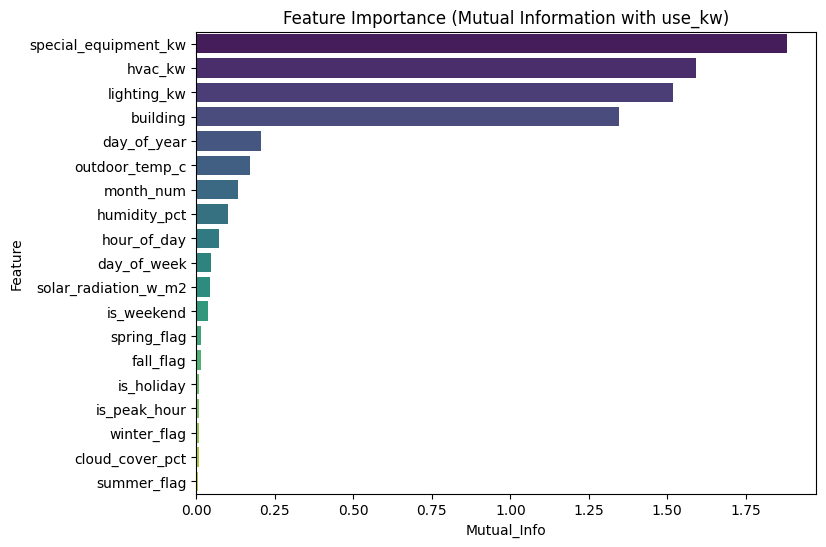

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.barplot(x='Mutual_Info', y='Feature', data=mi_df, palette='viridis')
plt.title("Feature Importance (Mutual Information with use_kw)")
plt.show()


#### Drop features with lowest MI (mutual info) :

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
import pandas as pd
import numpy as np

def select_features_by_mi(df, target_col, threshold=0.02):
    """
    Automatically select features based on mutual information with target.

    Args:
        df: DataFrame containing all features + target
        target_col: str, target column name
        threshold: float, minimum MI score to keep a feature

    Returns:
        selected_features: list of feature names kept
        mi_df: DataFrame of all features and their MI scores
    """

    df_copy = df.copy()
    
    # Encode categorical features
    for col in df_copy.columns:
        if df_copy[col].dtype == 'object':
            df_copy[col] = LabelEncoder().fit_transform(df_copy[col].astype(str))

    # Drop timestamp columns (if any)
    df_copy = df_copy.drop(columns=['time_ts'], errors='ignore')

    # Separate features and target
    X = df_copy.drop(columns=[target_col])
    y = df_copy[target_col]

    # Compute mutual information
    mi_scores = mutual_info_regression(X, y, discrete_features='auto', random_state=42)
    mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual_Info': mi_scores}).sort_values(by='Mutual_Info', ascending=False)

    # Automatically select features above threshold
    selected_features = mi_df[mi_df['Mutual_Info'] > threshold]['Feature'].tolist()

    print(f"✅ Selected {len(selected_features)} features out of {len(mi_df)} (threshold={threshold})")
    print(selected_features)

    return selected_features, mi_df

# Example usage:
selected_features, mi_df = select_features_by_mi(df, target_col='use_kw', threshold=0.02)


✅ Selected 12 features out of 19 (threshold=0.02)
['special_equipment_kw', 'hvac_kw', 'lighting_kw', 'building', 'day_of_year', 'outdoor_temp_c', 'month_num', 'humidity_pct', 'hour_of_day', 'day_of_week', 'solar_radiation_w_m2', 'is_weekend']


## Model training : 

In [31]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

X = df[selected_features]
y = df[['use_kw']]

# Sort by time first
df = df.sort_values(['building', 'time_ts'])

# Create a copy to avoid SettingWithCopyWarning
X = X.copy()

for col in X.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Normalize all numeric features
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Convert back to DataFrame to preserve order
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
y_scaled = pd.DataFrame(y_scaled, columns=['use_kw'], index=y.index)

# Keep building and time_ts separate - FIX: Extract Series directly
df_scaled = pd.concat([
    df[['building', 'time_ts']].reset_index(drop=True),
    X_scaled.reset_index(drop=True),
    y_scaled.reset_index(drop=True)
], axis=1)

# Ensure building is a proper Series
df_scaled['building'] = df_scaled['building'].squeeze()  # Convert any DataFrame to Series

df_scaled.head()


def create_sequences(data, target_col, seq_length=24):
    Xs, ys = [], []
    
    # Ensure building is a Series (not DataFrame)
    if isinstance(data['building'], pd.DataFrame):
        building_col = data['building'].iloc[:, 0]
    else:
        building_col = data['building']
    
    building_col = building_col.astype(str)
    
    feature_cols = [c for c in data.columns if c not in ['time_ts', 'building', target_col]]
    
    # Loop through unique buildings
    for bld in building_col.unique():
        group = data[building_col == bld].sort_values('time_ts').reset_index(drop=True)
        values = group[feature_cols].values
        target = group[target_col].values
        
        for i in range(seq_length, len(group)):
            Xs.append(values[i-seq_length:i])
            ys.append(target[i])
    
    return np.array(Xs), np.array(ys)

SEQ_LEN = 24
X_seq, y_seq = create_sequences(df_scaled, target_col='use_kw', seq_length=SEQ_LEN)
print(f"X_seq shape: {X_seq.shape}, y_seq shape: {y_seq.shape}")

X_seq shape: (209664, 24, 11), y_seq shape: (209664,)


In [32]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)
print(f"Train shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Test shapes: X={X_test.shape}, y={y_test.shape}")

Train shapes: X=(167731, 24, 11), y=(167731,)
Test shapes: X=(41933, 24, 11), y=(41933,)


In [34]:
import torch
import torch.nn as nn

class EnergyGRU(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super(EnergyGRU, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        
    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # use last timestep output
        return out

# Instantiate model
input_dim = X_train.shape[2]
model = EnergyGRU(input_dim)
print(model)

EnergyGRU(
  (gru): GRU(11, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [38]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 30
BATCH_SIZE = 64

# Create train and test data loaders
train_data = torch.utils.data.TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                            torch.tensor(y_train, dtype=torch.float32))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

test_data = torch.utils.data.TensorDataset(torch.tensor(X_test, dtype=torch.float32),
                                           torch.tensor(y_test, dtype=torch.float32))
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# Training loop
for epoch in range(EPOCHS):
    # Training phase
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    # Evaluation phase
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred.squeeze(), y_batch)
            test_loss += loss.item()
    
    # Print losses
    avg_train_loss = train_loss / len(train_loader)
    avg_test_loss = test_loss / len(test_loader)
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

Epoch 1/30, Train Loss: 0.0002, Test Loss: 0.0003
Epoch 2/30, Train Loss: 0.0002, Test Loss: 0.0003
Epoch 3/30, Train Loss: 0.0002, Test Loss: 0.0005
Epoch 4/30, Train Loss: 0.0002, Test Loss: 0.0003
Epoch 5/30, Train Loss: 0.0002, Test Loss: 0.0004
Epoch 6/30, Train Loss: 0.0002, Test Loss: 0.0005
Epoch 7/30, Train Loss: 0.0002, Test Loss: 0.0004
Epoch 8/30, Train Loss: 0.0002, Test Loss: 0.0003
Epoch 9/30, Train Loss: 0.0002, Test Loss: 0.0004
Epoch 10/30, Train Loss: 0.0002, Test Loss: 0.0005
Epoch 11/30, Train Loss: 0.0002, Test Loss: 0.0005
Epoch 12/30, Train Loss: 0.0002, Test Loss: 0.0004
Epoch 13/30, Train Loss: 0.0002, Test Loss: 0.0004
Epoch 14/30, Train Loss: 0.0002, Test Loss: 0.0005
Epoch 15/30, Train Loss: 0.0002, Test Loss: 0.0005
Epoch 16/30, Train Loss: 0.0002, Test Loss: 0.0004
Epoch 17/30, Train Loss: 0.0002, Test Loss: 0.0004
Epoch 18/30, Train Loss: 0.0002, Test Loss: 0.0004
Epoch 19/30, Train Loss: 0.0002, Test Loss: 0.0005
Epoch 20/30, Train Loss: 0.0002, Test Lo

In [40]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def evaluate_model(model, data_loader, dataset_name="Test"):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            y_pred = model(X_batch)
            all_preds.append(y_pred.squeeze().numpy())
            all_targets.append(y_batch.numpy())
    
    # Concatenate all predictions and targets
    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_targets)
    
    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    
    print(f"\n{dataset_name} Set Metrics:")
    print(f"  MSE (Mean Squared Error):  {mse:.4f}")
    print(f"  RMSE (Root Mean Squared Error): {rmse:.4f}")
    print(f"  MAE (Mean Absolute Error): {mae:.4f}")
    print(f"  R² Score: {r2:.4f}")
    print(f"  MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
    
    return y_true, y_pred, {'MSE': mse, 'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}

# Evaluate on train set
y_train_true, y_train_pred, train_metrics = evaluate_model(model, train_loader, "Train")

# Evaluate on test set
y_test_true, y_test_pred, test_metrics = evaluate_model(model, test_loader, "Test")


Train Set Metrics:
  MSE (Mean Squared Error):  0.0002
  RMSE (Root Mean Squared Error): 0.0146
  MAE (Mean Absolute Error): 0.0075
  R² Score: 0.9975
  MAPE (Mean Absolute Percentage Error): 39.92%

Test Set Metrics:
  MSE (Mean Squared Error):  0.0005
  RMSE (Root Mean Squared Error): 0.0217
  MAE (Mean Absolute Error): 0.0168
  R² Score: 0.8566
  MAPE (Mean Absolute Percentage Error): 12.60%


C:\Users\LENOVO\AppData\Local\Temp\ipykernel_21312\3320966824.py:94: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=['Actual', 'Predicted'], patch_artist=True)


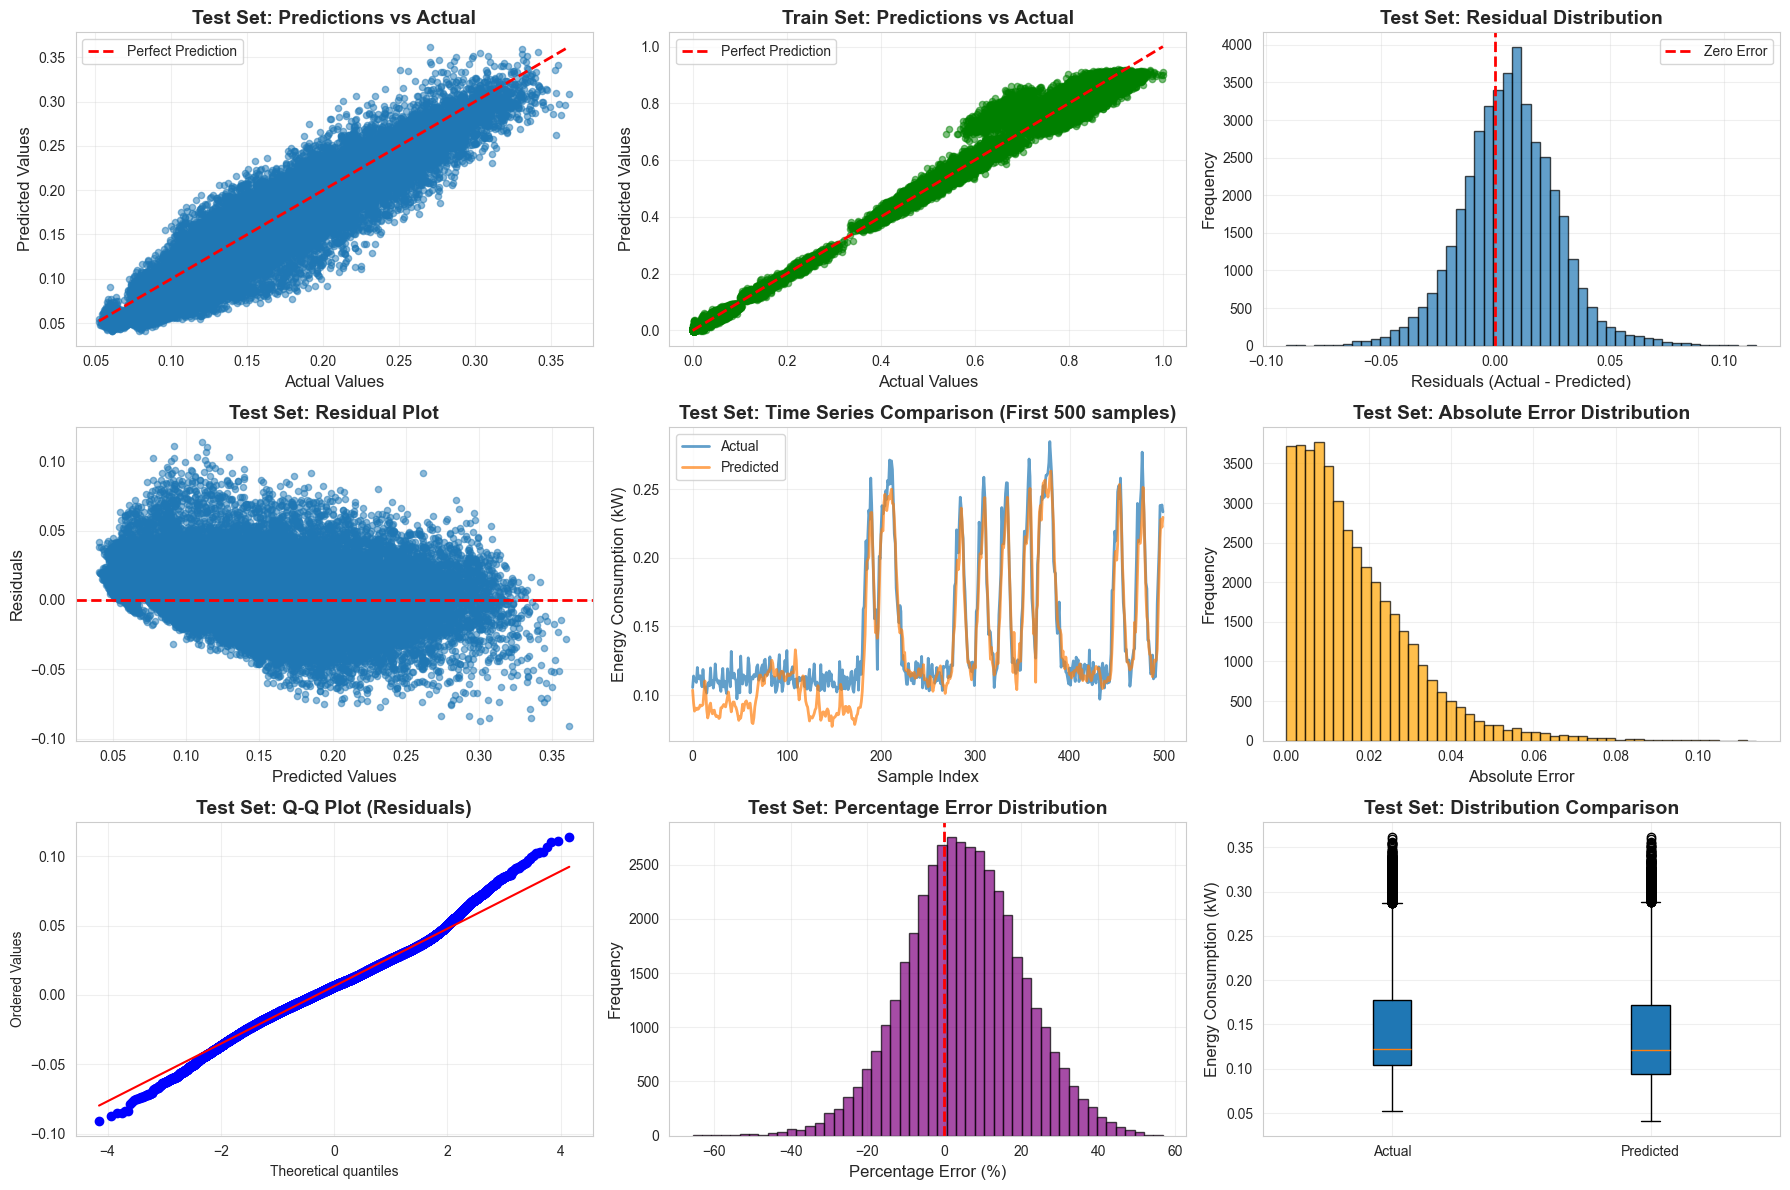

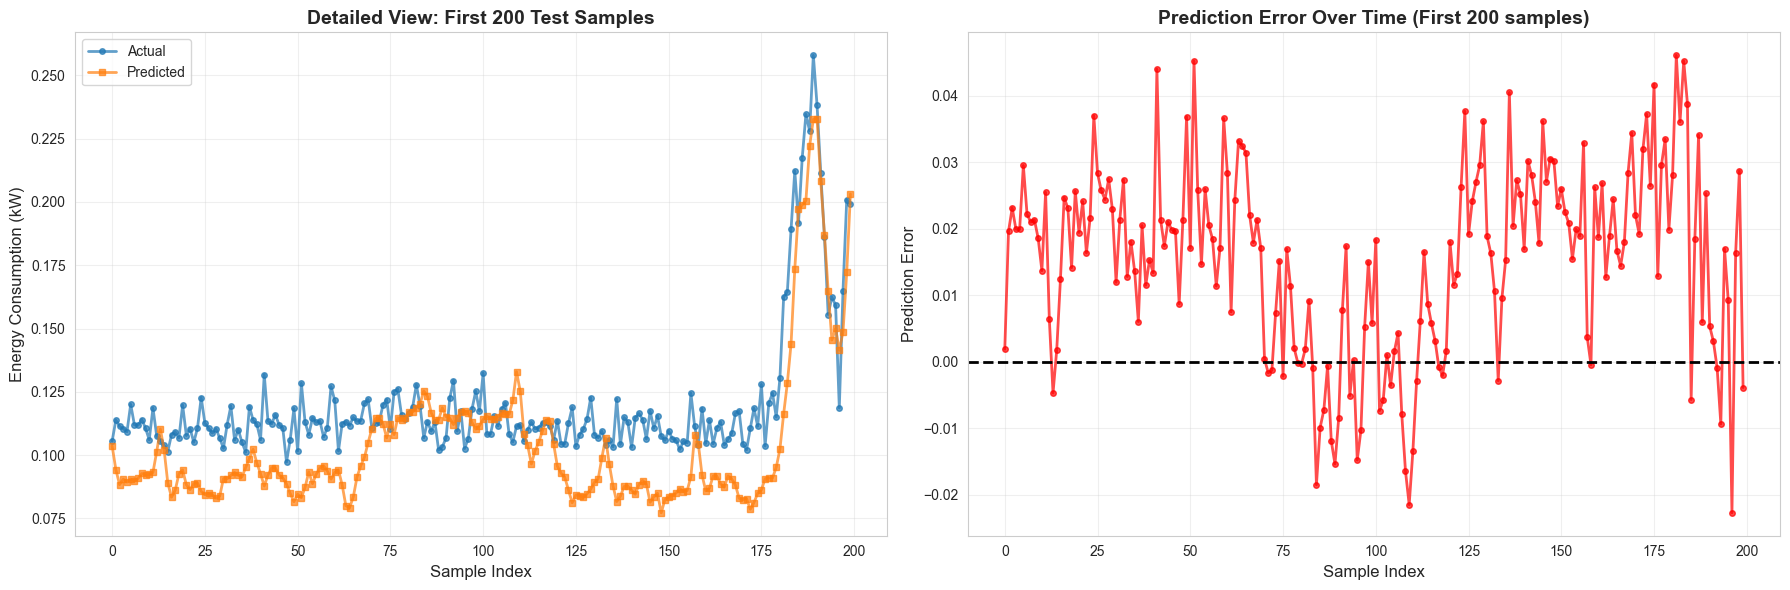


DETAILED ERROR ANALYSIS

Residual Statistics (Test Set):
  Mean Error: 0.0063
  Std Dev of Errors: 0.0208
  Min Error: -0.0912
  Max Error: 0.1141
  Median Error: 0.0063

Absolute Error Statistics (Test Set):
  Mean Absolute Error: 0.0168
  Median Absolute Error: 0.0134
  90th Percentile Error: 0.0346
  95th Percentile Error: 0.0428

Percentage Error Statistics (Test Set):
  Mean Percentage Error: 4.96%
  Median Percentage Error: 4.82%


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

# Create a comprehensive visualization
fig = plt.figure(figsize=(18, 12))

# 1. Actual vs Predicted Scatter Plot (Test Set)
plt.subplot(3, 3, 1)
plt.scatter(y_test_true, y_test_pred, alpha=0.5, s=20)
plt.plot([y_test_true.min(), y_test_true.max()], 
         [y_test_true.min(), y_test_true.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Test Set: Predictions vs Actual', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Actual vs Predicted Scatter Plot (Train Set)
plt.subplot(3, 3, 2)
plt.scatter(y_train_true, y_train_pred, alpha=0.5, s=20, color='green')
plt.plot([y_train_true.min(), y_train_true.max()], 
         [y_train_true.min(), y_train_true.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.title('Train Set: Predictions vs Actual', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 3. Residuals Distribution (Test Set)
plt.subplot(3, 3, 3)
residuals_test = y_test_true - y_test_pred
plt.hist(residuals_test, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
plt.xlabel('Residuals (Actual - Predicted)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Test Set: Residual Distribution', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Residuals vs Predicted Values (Test Set)
plt.subplot(3, 3, 4)
plt.scatter(y_test_pred, residuals_test, alpha=0.5, s=20)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.title('Test Set: Residual Plot', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# 5. Time Series Plot - Sample (First 500 points of test set)
plt.subplot(3, 3, 5)
sample_size = min(500, len(y_test_true))
indices = range(sample_size)
plt.plot(indices, y_test_true[:sample_size], label='Actual', linewidth=2, alpha=0.7)
plt.plot(indices, y_test_pred[:sample_size], label='Predicted', linewidth=2, alpha=0.7)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Energy Consumption (kW)', fontsize=12)
plt.title('Test Set: Time Series Comparison (First 500 samples)', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# 6. Error Distribution (Absolute Error)
plt.subplot(3, 3, 6)
abs_errors = np.abs(residuals_test)
plt.hist(abs_errors, bins=50, edgecolor='black', alpha=0.7, color='orange')
plt.xlabel('Absolute Error', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Test Set: Absolute Error Distribution', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# 7. Q-Q Plot (Normal Distribution Check for Residuals)
plt.subplot(3, 3, 7)
from scipy import stats
stats.probplot(residuals_test, dist="norm", plot=plt)
plt.title('Test Set: Q-Q Plot (Residuals)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# 8. Prediction Error Percentage
plt.subplot(3, 3, 8)
percentage_error = (residuals_test / (y_test_true + 1e-8)) * 100
plt.hist(percentage_error, bins=50, edgecolor='black', alpha=0.7, color='purple')
plt.axvline(x=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Percentage Error (%)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Test Set: Percentage Error Distribution', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# 9. Box Plot Comparison
plt.subplot(3, 3, 9)
box_data = [y_test_true, y_test_pred]
plt.boxplot(box_data, labels=['Actual', 'Predicted'], patch_artist=True)
plt.ylabel('Energy Consumption (kW)', fontsize=12)
plt.title('Test Set: Distribution Comparison', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Additional detailed time series plot
plt.figure(figsize=(18, 6))

# Zoom in on a smaller window for better visibility
zoom_size = min(200, len(y_test_true))
plt.subplot(1, 2, 1)
plt.plot(range(zoom_size), y_test_true[:zoom_size], 'o-', label='Actual', 
         linewidth=2, markersize=4, alpha=0.7)
plt.plot(range(zoom_size), y_test_pred[:zoom_size], 's-', label='Predicted', 
         linewidth=2, markersize=4, alpha=0.7)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Energy Consumption (kW)', fontsize=12)
plt.title(f'Detailed View: First {zoom_size} Test Samples', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Error over time
plt.subplot(1, 2, 2)
plt.plot(range(zoom_size), residuals_test[:zoom_size], 'o-', color='red', 
         linewidth=2, markersize=4, alpha=0.7)
plt.axhline(y=0, color='black', linestyle='--', linewidth=2)
plt.xlabel('Sample Index', fontsize=12)
plt.ylabel('Prediction Error', fontsize=12)
plt.title(f'Prediction Error Over Time (First {zoom_size} samples)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print Summary Statistics
print("\n" + "="*60)
print("DETAILED ERROR ANALYSIS")
print("="*60)
print(f"\nResidual Statistics (Test Set):")
print(f"  Mean Error: {np.mean(residuals_test):.4f}")
print(f"  Std Dev of Errors: {np.std(residuals_test):.4f}")
print(f"  Min Error: {np.min(residuals_test):.4f}")
print(f"  Max Error: {np.max(residuals_test):.4f}")
print(f"  Median Error: {np.median(residuals_test):.4f}")

print(f"\nAbsolute Error Statistics (Test Set):")
print(f"  Mean Absolute Error: {np.mean(abs_errors):.4f}")
print(f"  Median Absolute Error: {np.median(abs_errors):.4f}")
print(f"  90th Percentile Error: {np.percentile(abs_errors, 90):.4f}")
print(f"  95th Percentile Error: {np.percentile(abs_errors, 95):.4f}")

print(f"\nPercentage Error Statistics (Test Set):")
print(f"  Mean Percentage Error: {np.mean(percentage_error):.2f}%")
print(f"  Median Percentage Error: {np.median(percentage_error):.2f}%")
print("="*60)

### Feed the model some data to test predictions : 

In [43]:
def prepare_input_data(input_df, selected_features, scaler_X, building_col='building', time_col='time_ts'):
    """Prepare input data for prediction"""
    df_prep = input_df.copy()
    
    # Check and fill missing features
    missing_features = [f for f in selected_features if f not in df_prep.columns]
    if missing_features:
        print(f"⚠️ Missing {len(missing_features)} features - filling with zeros")
        for feat in missing_features:
            df_prep[feat] = 0
    
    # Encode categorical features
    for col in df_prep[selected_features].select_dtypes(include=['object']).columns:
        le = LabelEncoder()
        df_prep[col] = le.fit_transform(df_prep[col].astype(str))
    
    # Scale features
    X_scaled = scaler_X.transform(df_prep[selected_features])
    X_scaled_df = pd.DataFrame(X_scaled, columns=selected_features, index=df_prep.index)
    
    # Remove building and time from selected_features if they exist
    feature_cols = [f for f in selected_features if f not in [building_col, time_col]]
    
    # Combine - keep only one copy of building and time_ts
    prepared_df = df_prep[[building_col, time_col]].copy()
    for col in feature_cols:
        prepared_df[col] = X_scaled_df[col]
    
    return prepared_df


def predict_sequences(model, input_df, selected_features, scaler_X, scaler_y, 
                     seq_length=24, building_col='building', time_col='time_ts'):
    """Make predictions on new data"""
    df_prepared = prepare_input_data(input_df, selected_features, scaler_X, building_col, time_col)
    df_prepared = df_prepared.sort_values([building_col, time_col])
    
    model.eval()
    all_predictions = []
    all_timestamps = []
    all_buildings = []
    
    feature_cols = [f for f in selected_features if f not in [building_col, time_col]]
    
    for building in df_prepared[building_col].unique():
        building_data = df_prepared[df_prepared[building_col] == building].reset_index(drop=True)
        
        if len(building_data) < seq_length:
            print(f"⚠️ Building '{building}' has only {len(building_data)} records. Need {seq_length}. Skipping.")
            continue
        
        feature_values = building_data[feature_cols].values
        
        with torch.no_grad():
            for i in range(seq_length, len(building_data)):
                sequence = feature_values[i-seq_length:i]
                sequence_tensor = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0)
                
                prediction_scaled = model(sequence_tensor).squeeze().numpy()
                prediction = scaler_y.inverse_transform([[prediction_scaled]])[0][0]
                
                all_predictions.append(prediction)
                all_timestamps.append(building_data.loc[i, time_col])
                all_buildings.append(building)
    
    predictions_df = pd.DataFrame({
        'time_ts': all_timestamps,
        'building': all_buildings,
        'predicted_use_kw': all_predictions
    })
    
    print(f"✅ Generated {len(predictions_df)} predictions")
    return predictions_df

Time Information:
First timestamp: 2025-01-02 00:00:00
Last timestamp: 2025-01-03 23:00:00
Time difference between records: 0 days 01:00:00
Total duration: 1 days 23:00:00


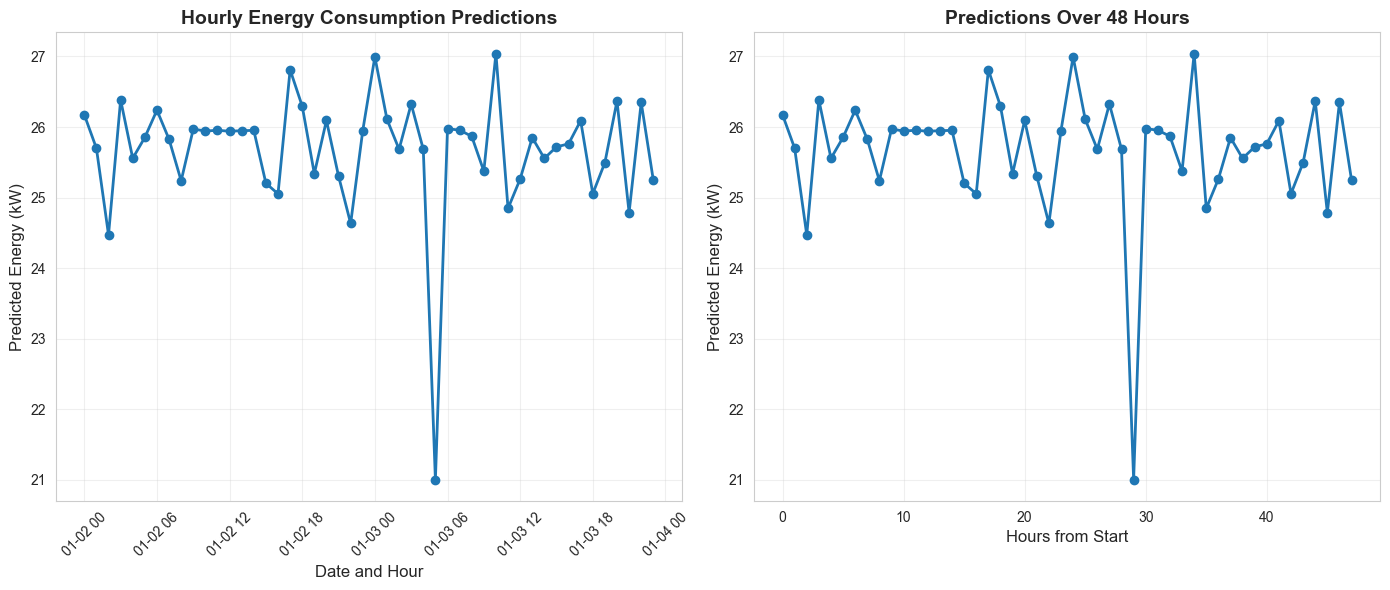


Sample of hourly predictions:
               time_ts  predicted_use_kw  building
0  2025-01-02 00:00:00         26.174002         0
1  2025-01-02 01:00:00         25.699523         0
2  2025-01-02 02:00:00         24.471908         0
3  2025-01-02 03:00:00         26.384665         0
4  2025-01-02 04:00:00         25.556765         0
5  2025-01-02 05:00:00         25.852978         0
6  2025-01-02 06:00:00         26.238510         0
7  2025-01-02 07:00:00         25.826202         0
8  2025-01-02 08:00:00         25.238795         0
9  2025-01-02 09:00:00         25.970617         0
10 2025-01-02 10:00:00         25.944101         0
11 2025-01-02 11:00:00         25.953292         0
12 2025-01-02 12:00:00         25.940777         0
13 2025-01-02 13:00:00         25.947932         0
14 2025-01-02 14:00:00         25.952863         0
15 2025-01-02 15:00:00         25.203556         0
16 2025-01-02 16:00:00         25.053126         0
17 2025-01-02 17:00:00         26.811263         0


In [ ]:
# Check the time frequency
print("Time Information:")
print(f"First timestamp: {predictions['time_ts'].iloc[0]}")
print(f"Last timestamp: {predictions['time_ts'].iloc[-1]}")
print(f"Time difference between records: {predictions['time_ts'].iloc[1] - predictions['time_ts'].iloc[0]}")
print(f"Total duration: {predictions['time_ts'].iloc[-1] - predictions['time_ts'].iloc[0]}")

# Better visualization with clearer time labels
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(predictions['time_ts'], predictions['predicted_use_kw'], 'o-', linewidth=2)
plt.xlabel('Date and Hour', fontsize=12)
plt.ylabel('Predicted Energy (kW)', fontsize=12)
plt.title('Hourly Energy Consumption Predictions', fontsize=14, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Add hour labels
plt.subplot(1, 2, 2)
predictions['hour'] = predictions['time_ts'].dt.hour
predictions['date'] = predictions['time_ts'].dt.date
plt.plot(range(len(predictions)), predictions['predicted_use_kw'], 'o-', linewidth=2)
plt.xlabel('Hours from Start', fontsize=12)
plt.ylabel('Predicted Energy (kW)', fontsize=12)
plt.title(f'Predictions Over {len(predictions)} Hours', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Show hourly pattern
print("\nSample of hourly predictions:")
print(predictions[['time_ts', 'predicted_use_kw']].head(24))  # Show first 24 hours (1 day)

### Save the model :

In [57]:
# ...existing code...
import os
import json
import joblib
import pickle
import torch
import numpy as np

def _make_json_safe(obj):
    """Recursively convert numpy/torch types to Python native types so json.dump works."""
    if isinstance(obj, dict):
        return {k: _make_json_safe(v) for k, v in obj.items()}
    if isinstance(obj, (list, tuple)):
        return [_make_json_safe(v) for v in obj]
    if isinstance(obj, (np.ndarray,)):
        return _make_json_safe(obj.tolist())
    if isinstance(obj, (np.generic,)):
        # numpy scalar
        return obj.item()
    if isinstance(obj, torch.Tensor):
        return _make_json_safe(obj.detach().cpu().numpy())
    if isinstance(obj, (bytes, bytearray)):
        try:
            return obj.decode()
        except Exception:
            return str(obj)
    if isinstance(obj, (int, float, str, bool, type(None))):
        return obj
    # fallback: try casting to float/int then str
    try:
        return float(obj)
    except Exception:
        try:
            return int(obj)
        except Exception:
            return str(obj)


def save_model_artifacts(save_dir=None,
                         model=None,
                         optimizer=None,
                         epoch=None,
                         scaler_X=None,
                         scaler_y=None,
                         label_encoders=None,
                         selected_features=None,
                         training_history=None,
                         model_config=None):
    """
    Save model artifacts. If save_dir is None uses current working directory
    (i.e. the notebook directory when run from the notebook).
    """


    if save_dir is None:
        # Define the directory name
        folder_name = "model_artifacts"
        save_dir = os.path.join(os.getcwd(), folder_name)  # notebook working directory + folder_name
    os.makedirs(save_dir, exist_ok=True)

    # 1) State dict (recommended)
    if model is not None:
        torch.save(model.state_dict(), os.path.join(save_dir, "model_state_dict.pth"))
        # save a checkpoint with optimizer + epoch if provided
        checkpoint = {"model_state_dict": model.state_dict()}
        if optimizer is not None:
            checkpoint["optimizer_state_dict"] = optimizer.state_dict()
        if epoch is not None:
            checkpoint["epoch"] = int(epoch) if not isinstance(epoch, (dict, list)) else _make_json_safe(epoch)
        torch.save(checkpoint, os.path.join(save_dir, "checkpoint.pth"))

        # also try to save whole model on CPU (optional)
        try:
            cpu_model = model.to("cpu")
            torch.save(cpu_model, os.path.join(save_dir, "model_full.pth"))
        except Exception:
            pass

    # 2) Scalers
    if scaler_X is not None:
        joblib.dump(scaler_X, os.path.join(save_dir, "scaler_X.joblib"))
    if scaler_y is not None:
        joblib.dump(scaler_y, os.path.join(save_dir, "scaler_y.joblib"))

    # 3) Label encoders
    if label_encoders is not None:
        with open(os.path.join(save_dir, "label_encoders.pkl"), "wb") as f:
            pickle.dump(label_encoders, f)

    # 4) Selected features / model config
    if selected_features is not None:
        with open(os.path.join(save_dir, "selected_features.json"), "w", encoding="utf-8") as f:
            json.dump(_make_json_safe(selected_features), f, ensure_ascii=False, indent=2)
    if model_config is not None:
        with open(os.path.join(save_dir, "model_config.json"), "w", encoding="utf-8") as f:
            json.dump(_make_json_safe(model_config), f, ensure_ascii=False, indent=2)

    # 5) Training history / metrics (make JSON-safe)
    if training_history is not None:
        safe_history = _make_json_safe(training_history)
        with open(os.path.join(save_dir, "training_history.json"), "w", encoding="utf-8") as f:
            json.dump(safe_history, f, ensure_ascii=False, indent=2)

    print(f"✅ Saved model artifacts to {folder_name}/")
# ...existing code...

In [58]:
save_model_artifacts(
    save_dir=None,            # use notebook directory
    model=model,
    optimizer=optimizer,
    epoch=EPOCHS,
    scaler_X=scaler_X,
    scaler_y=scaler_y,
    label_encoders=None,
    selected_features=selected_features,
    training_history={'train': train_metrics, 'test': test_metrics},
    model_config={'input_dim': input_dim, 'hidden_dim': model.gru.hidden_size, 'num_layers': model.gru.num_layers}
)

✅ Saved model artifacts to model_artifacts/
